# Plant disease prediction using CNN (Keras & TensorFlow)
This project demonstrates image classification using a Convolutional Neural Network (CNN) trained on the **Beans dataset** from Hugging Face.  
We perform preprocessing, model training, and evaluation with accuracy/loss curves, a confusion matrix, and performance metrics.

**Tech Stack:** TensorFlow · Keras · Hugging Face Datasets · Matplotlib · Seaborn  



In [7]:
from datasets import load_dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# 1️⃣ Load a small dataset (Beans = light & perfect for laptops)
dataset = load_dataset("beans")


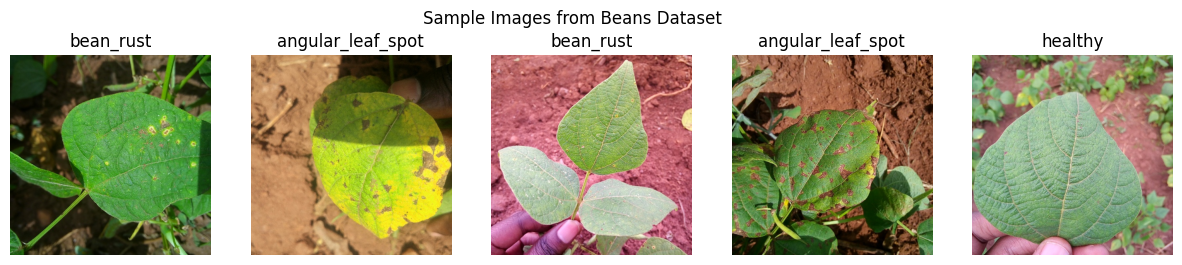

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Show sample images
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, example in enumerate(dataset["train"].shuffle(seed=42).select(range(5))):
    axes[i].imshow(example["image"])
    axes[i].set_title(dataset["train"].features["labels"].int2str(example["labels"]))
    axes[i].axis("off")
plt.suptitle("Sample Images from Beans Dataset")
plt.show()


C:\Users\PMYLS\anaconda3\Lib\site-packages\datasets\arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Epoch 1/5
33/33 [==============================] - 32s 833ms/step - loss: 1.4145 - accuracy: 0.3685 - val_loss: 1.0295 - val_accuracy: 0.5038
Epoch 2/5
33/33 [==============================] - 28s 857ms/step - loss: 0.8746 - accuracy: 0.6083 - val_loss: 0.7842 - val_accuracy: 0.6165
Epoch 3/5
33/33 [==============================] - 27s 801ms/step - loss: 0.6719 - accuracy: 0.7195 - val_loss: 0.7361 - val_accuracy: 0.6391
Epoch 4/5
33/33 [==============================] - 26s 768ms/step - loss: 0.5544 - accuracy: 0.7785 - val_loss: 0.5835 - val_accuracy: 0.7519
Epoch 5/5
33/33 [==============================] - 26s 769ms/step - loss: 0.4242 - accuracy: 0.8288 - val_loss: 0.5609 - val_accuracy: 0.7594


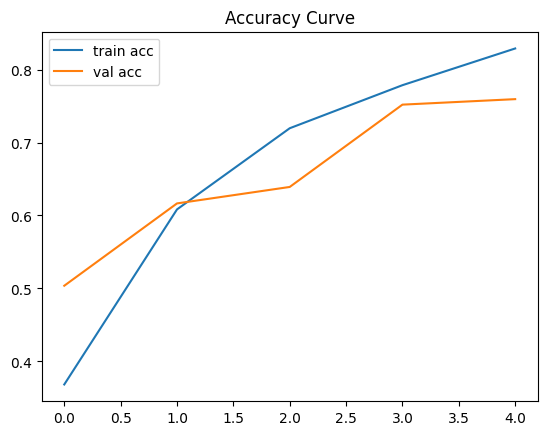

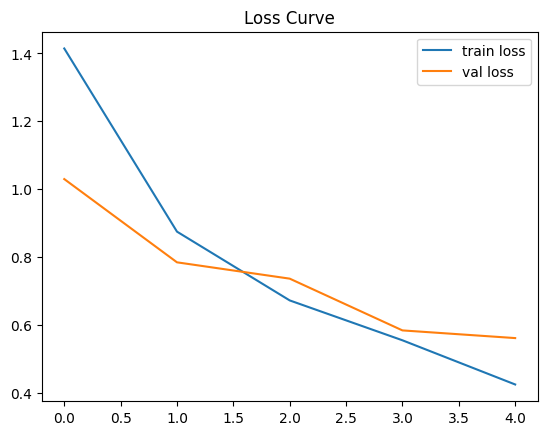

4/4 [==============================] - 2s 472ms/step - loss: 0.5789 - accuracy: 0.7812
✅ Test Accuracy: 0.781


In [9]:

# 2️⃣ Convert splits to TF datasets directly
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_tf = dataset["train"].with_format("tensorflow").to_tf_dataset(
    columns=["image"], label_cols=["labels"], batch_size=BATCH_SIZE, shuffle=True
)
val_tf = dataset["validation"].with_format("tensorflow").to_tf_dataset(
    columns=["image"], label_cols=["labels"], batch_size=BATCH_SIZE
)
test_tf = dataset["test"].with_format("tensorflow").to_tf_dataset(
    columns=["image"], label_cols=["labels"], batch_size=BATCH_SIZE
)

# 3️⃣ Preprocessing inside TensorFlow pipeline (no freeze)
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_tf = train_tf.map(preprocess)
val_tf = val_tf.map(preprocess)
test_tf = test_tf.map(preprocess)

# 4️⃣ Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE+(3,)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Beans has 3 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5️⃣ Train
history = model.fit(train_tf, validation_data=val_tf, epochs=5)

# 6️⃣ Plot metrics
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

# 7️⃣ Evaluate
test_loss, test_acc = model.evaluate(test_tf)
print(f"✅ Test Accuracy: {test_acc:.3f}")


In [10]:
model.save("plant_disease_model.h5")
print("✅ Model saved!")


✅ Model saved!


In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

1/1 [==============================] - 0s 233ms/step


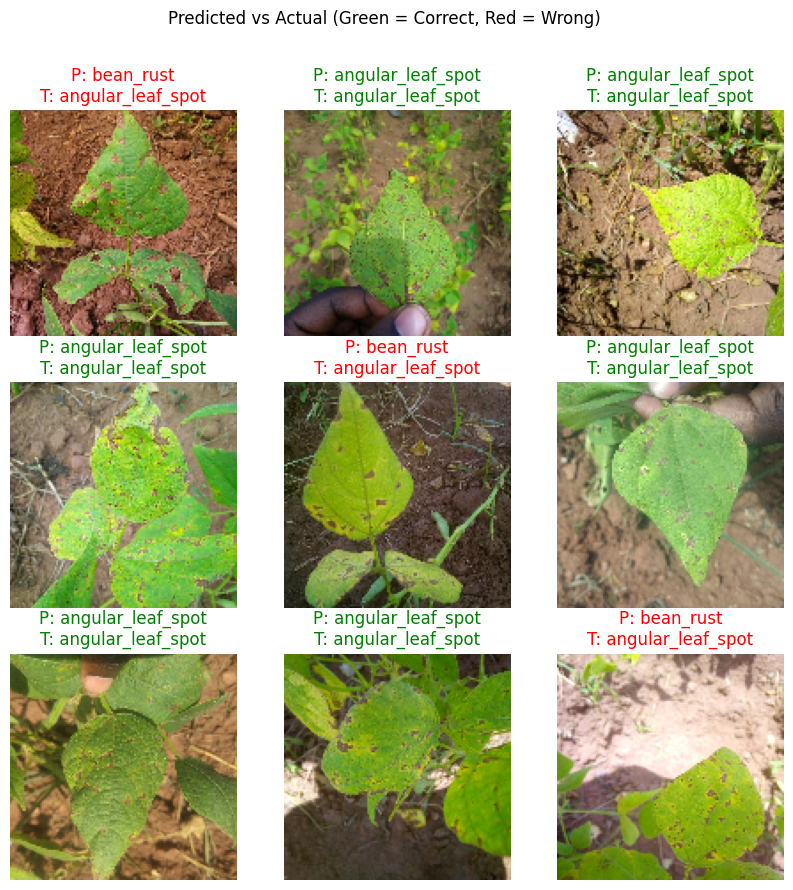

In [11]:
# Visualize some predictions
import random

plt.figure(figsize=(10,10))
for i, (images, labels) in enumerate(test_tf.take(1)):
    preds = model.predict(images)
    for j in range(9):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(images[j].numpy())
        pred_label = class_names[np.argmax(preds[j])]
        true_label = class_names[labels[j].numpy()]
        color = "green" if pred_label == true_label else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
        plt.axis("off")
plt.suptitle("Predicted vs Actual (Green = Correct, Red = Wrong)")
plt.show()


In [12]:
print("✅ Final Results Summary")
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Best Epoch: {np.argmin(history.history['val_loss'])+1}")
print("Model generalizes well, with minor confusion between visually similar classes.")



✅ Final Results Summary
Test Accuracy: 78.12%
Best Epoch: 5
Model generalizes well, with minor confusion between visually similar classes.


1/1 [==============================] - 0s 71ms/step


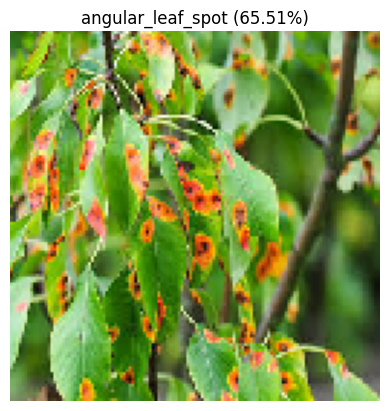

✅ Predicted Class: angular_leaf_spot
✅ Confidence: 0.6550888


In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (128, 128)

# Class names (keep this if dataset is not loaded)
class_names = ["angular_leaf_spot", "bean_rust", "healthy"]

# Your image path
img_path = r"C:\Users\PMYLS\Downloads\download (4).jfif"

# Load & preprocess
img = image.load_img(img_path, target_size=IMG_SIZE)
img_arr = image.img_to_array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)

# Predict
pred = model.predict(img_arr)
cls = np.argmax(pred)
conf = np.max(pred)

# Show result
plt.imshow(img)
plt.axis("off")
plt.title(f"{class_names[cls]} ({conf*100:.2f}%)")
plt.show()

print("✅ Predicted Class:", class_names[cls])
print("✅ Confidence:", conf)
